<div align='center'>
    <img src='https://neurohive.io/wp-content/uploads/2019/05/Screenshot-from-2019-05-29-21-23-47.png')', width='100%'>
</div>
Решения соревнования "Digit Recognizer"  https://www.kaggle.com/competitions/digit-recognizer/overview/

## 1. Загружаем библиотеки и данные.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import torch
from torch import tensor, nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv') # Загружаем тренировочные данные
test = pd.read_csv('test.csv') # Загружаем тестовые данные
sample_sub = pd.read_csv('sample_submission.csv') # Загружаем бланк ответов
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.tail(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41990,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41991,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41992,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41993,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41994,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. EDA (Первичный анализ данных).

In [4]:
print(f"Тренировочные данные содержат {train.shape[0]} записей и {train.shape[1]} признаков")

Тренировочные данные содержат 42000 записей и 785 признаков


In [5]:
print(f"Тестовых данные содержится {test.shape[0]} записей и {test.shape[1]} признаков")

Тестовых данные содержится 28000 записей и 784 признаков


In [6]:
print(f"Количество пропущенных данных: {train.isnull().sum().sum()}")

Количество пропущенных данных: 0


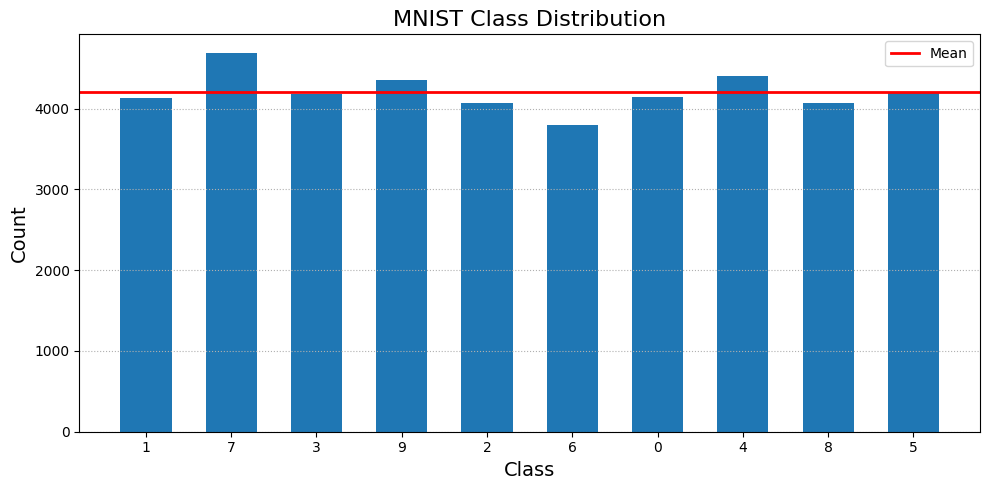

In [7]:
labels = train.label.value_counts().index # Получаем названия классов
counts = train.label.value_counts() # Получаем количество строк по классам

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, width=0.6)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Count', fontsize=14) # Добавляем текст на ось Y
plt.title('MNIST Class Distribution', fontsize=16) # Добавляем заголовок об распределение классов

# Добавляем линию, чтобы показать равномерность распределения признаков
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')

plt.legend()
plt.grid(axis='y', linestyle='dotted')

plt.tight_layout()
plt.show()

##### Выводы по второму блоку:

    1. Отсутствуют пропущенные данные.
    2. Признаки для классификации одинаковые для тренировочных и тестовых данных.
    3. Все классы распределены +- равномерно.

## 3. Предобработка данных.

### 3.1. Предобработка тренировочных и тестовых данных.

In [8]:
# Изменяем глубину цвета от 0 до 1
X = train.drop('label', axis=1) # Оставляем чисто изображение
X = np.array(X)
X = X.astype('float32')
X = X / 255.0

# Конвертируем изображение из одного канала в RGB
X = cv2.cvtColor(X, cv2.COLOR_GRAY2RGB)
X = X.reshape(-1, 28, 28, 3)

# Изменяем размерность до 30x30 пикселей
newX = []
for image in X:
    image = cv2.resize(image, dsize=(30, 30), interpolation=cv2.INTER_AREA)
    newX.append(image)
newX = np.array(newX)
newX = newX.astype('float32')
newX = newX / 255.0
X = newX.reshape(-1, 3, 30, 30)

# Получаем список целевой метрики
y = train.label 

In [9]:
test = np.array(test)
test = test.astype('float32')
test = test / 255.0
test = cv2.cvtColor(test, cv2.COLOR_GRAY2RGB)
test = test.reshape(-1, 28, 28, 3)
newX = []
for image in test:
    image = cv2.resize(image, dsize=(30, 30), interpolation=cv2.INTER_AREA)
    newX.append(image)
newX = np.array(newX)
newX = newX.astype('float32')
newX = newX / 255.0
test = newX.reshape(-1, 3, 30, 30)

### 3.2. Формируем тренировочную и валидационную выборку. Создаём датасеты для нейросети.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_t =  torch.from_numpy(X_train).float()
y_train_t =  torch.from_numpy(y_train.values)
X_val_t =  torch.from_numpy(X_val).float()
y_val_t =  torch.from_numpy(y_val.values)

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)

## 4. Создание нейронной сети и обучение её.

### 4.1. Выбор устройства для обучения модели.

In [12]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

### 4.2. Объявление структуры нейронной сети.

In [13]:
model = models.densenet121() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1024, 10) # Замена слоя классификации
model.to(device) # Загрузка модели на устройство

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": val_dataloader}

### 4.3. Процесс обучения нейронной сети

In [15]:
max_epochs = 500
best_model = model # Лучшая модель
last_loss = np.Inf # Последняя ошибка
epoch_erly_stopping = 0
flag = False 
col_not_best = 0 # Количество эпох без изменений
accyracy_best = 0 # Лучшая точность 
accuracy_history = {"train": [], "valid": []} # История точности на выборках
loss_history = {"train": [], "valid": []} # История ошибки на выборках
train_losses = [] 
valid_losses = []
start_time = datetime.now()
for epoch in range(max_epochs+1):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Переносим на устройсво данные
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() # Обнуляем градиенты ошибок
                outp = model(x_batch) # Получаем ответы от модели
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # Softmax, получаем класс
            correct = (preds == y_batch).sum() # Кол-во правильных ответов
            all = preds.size(0) # Кол-во всех ответов
            epoch_correct += correct.item() # Кол-во фото корректно распознанных
            epoch_all += all # Общее кол-во фото 
            loss = criterion(outp, y_batch) # Вычисляем градиети
            if k == "train":
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            else:
                valid_losses.append(loss.item())

        if k == "valid":
            train_loss = np.average(train_losses)
            valid_loss = np.average(valid_losses)
            loss_history["train"].append(train_loss)
            loss_history["valid"].append(valid_loss)
            print(f"[{epoch:>3}/{max_epochs:>3}] loss train: {train_loss:.5f} | loss valid: {valid_loss:.5f}")

            # Если ошибка упала, то сохраняем как лучшую модель
            if round(last_loss, 5) > round(valid_loss, 5):
                col_not_best = 0
                best_model = model
                epoch_erly_stopping = epoch
                torch.save(best_model, "checkpoint.pt")
                print(f"Validation loss decreased ({last_loss:.5f} --> {valid_loss:.5f}).  Saving model ...")
                last_loss = valid_loss
            else:
                # Проверяем на отсутсвие роста 20 эпох
                if col_not_best + 1 >= 20:
                    print("Early stopping!")
                    accuracy_history[k].append(epoch_correct/epoch_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
                    print(f"EarlyStopping counter: {col_not_best} out of 20")                  
        accuracy_history[k].append(epoch_correct/epoch_all)
    if flag:
        break
torch.save(best_model, "model121.pth")
print(f'Program execution time: {datetime.now() - start_time}')

[  0/500] loss train: 0.32369 | loss valid: 0.16145
Validation loss decreased (inf --> 0.16145).  Saving model ...
[  1/500] loss train: 0.23151 | loss valid: 0.13803
Validation loss decreased (0.16145 --> 0.13803).  Saving model ...
[  2/500] loss train: 0.18314 | loss valid: 0.12631
Validation loss decreased (0.13803 --> 0.12631).  Saving model ...
[  3/500] loss train: 0.15375 | loss valid: 0.12377
Validation loss decreased (0.12631 --> 0.12377).  Saving model ...
[  4/500] loss train: 0.13482 | loss valid: 0.11817
Validation loss decreased (0.12377 --> 0.11817).  Saving model ...
[  5/500] loss train: 0.12002 | loss valid: 0.11364
Validation loss decreased (0.11817 --> 0.11364).  Saving model ...
[  6/500] loss train: 0.10847 | loss valid: 0.11213
Validation loss decreased (0.11364 --> 0.11213).  Saving model ...
[  7/500] loss train: 0.09941 | loss valid: 0.11073
Validation loss decreased (0.11213 --> 0.11073).  Saving model ...
[  8/500] loss train: 0.09206 | loss valid: 0.11201


### 4.4. Анализ точность от эпохи обучения нейронной сети.

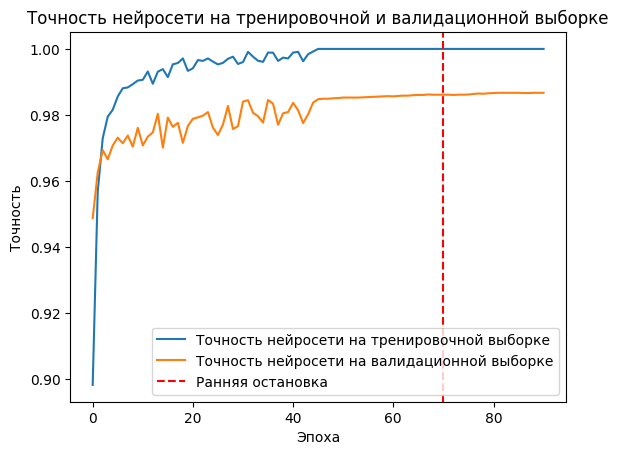

In [16]:
plt.plot(accuracy_history['train'], label='Точность нейросети на тренировочной выборке')
plt.plot(accuracy_history['valid'], label='Точность нейросети на валидационной выборке')
plt.title('Точность нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

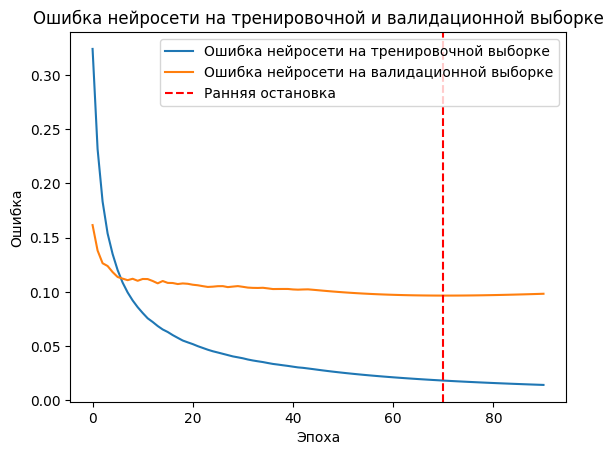

In [17]:
plt.plot(loss_history["train"], label='Ошибка нейросети на тренировочной выборке')
plt.plot(loss_history["valid"], label='Ошибка нейросети на валидационной выборке')
plt.title('Ошибка нейросети на тренировочной и валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.axvline(epoch_erly_stopping, color='red', linestyle='--', label='Ранняя остановка')
plt.legend()
plt.show()

## 5. Предсказание нейронной сети на тестовой выборке.

In [18]:
test_t =  torch.from_numpy(test).to(device)

In [19]:
with torch.no_grad():
    best_model.eval() # Переводим модель в состояние предсказаний
    outp = model(test_t) # Получаем ответы по 10 классам
preds = outp.argmax(-1) # Оставляем класс с максимальным значением

In [20]:
preds = preds.detach().cpu().numpy() # Проверяем всё ли правильно получается на выходе
preds

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [21]:
output = pd.DataFrame({'ImageId':sample_sub.ImageId, 'Label':preds})
output.to_csv('submission.csv', index=False)

В результате на тестовых данных нейросеть показала точность в 98.489%, что является отличным результатом.